In [1]:
!pip install -q --upgrade transformers==4.25.1 diffusers ftfy accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.9/93.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 32.3 MB/s eta 0:00:00


In [2]:
from base64 import b64encode

import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import os

torch.manual_seed(1)
if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
if "mps" == torch_device: os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = "1"

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


0it [00:00, ?it/s]

In [3]:
# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

In [4]:
# Prep Scheduler
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32)

def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

def get_output_embeds(input_embeddings):
    # CLIP's text model uses causal mask, so we prepare it here:
    bsz, seq_len = input_embeddings.shape[:2]
    causal_attention_mask = text_encoder.text_model._build_causal_attention_mask(bsz, seq_len, dtype=input_embeddings.dtype)

    # Getting the output embeddings involves calling the model with passing output_hidden_states=True
    # so that it doesn't just return the pooled final predictions:
    encoder_outputs = text_encoder.text_model.encoder(
        inputs_embeds=input_embeddings,
        attention_mask=None, # We aren't using an attention mask so that can be None
        causal_attention_mask=causal_attention_mask.to(torch_device),
        output_attentions=None,
        output_hidden_states=True, # We want the output embs not the final output
        return_dict=None,
    )

    # We're interested in the output hidden state only
    output = encoder_outputs[0]

    # There is a final layer norm we need to pass these through
    output = text_encoder.text_model.final_layer_norm(output)

    # And now they're ready!
    return output

#Generating an image with these modified embeddings

def generate_with_embs(text_embeddings, seed):
    height = 512                        # default height of Stable Diffusion
    width = 512                         # default width of Stable Diffusion
    num_inference_steps = 30            # Number of denoising steps
    guidance_scale = 7.5                # Scale for classifier-free guidance
    generator = torch.manual_seed(seed)   # Seed generator to create the inital latent noise
    batch_size = 1

    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    set_timesteps(scheduler, num_inference_steps)

    # Prep latents
    latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    return latents_to_pil(latents)[0]

In [5]:
# Our text prompt
prompt = 'A picture of a puppy'

# Turn the text into a sequnce of tokens:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
text_input['input_ids'][0] # View the tokens

tensor([49406,   320,  1674,   539,   320,  6829, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407])

In [6]:
# See the individual tokens
for t in text_input['input_ids'][0][:8]: # We'll just look at the first 7 to save you from a wall of '<|endoftext|>'
    print(t, tokenizer.decoder.get(int(t)))

tensor(49406) <|startoftext|>
tensor(320) a</w>
tensor(1674) picture</w>
tensor(539) of</w>
tensor(320) a</w>
tensor(6829) puppy</w>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>


In [7]:
# Grab the output embeddings
output_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
print('Shape:', output_embeddings.shape)
output_embeddings

Shape: torch.Size([1, 77, 768])


tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 0.6942,  0.3538,  1.0991,  ..., -1.5716, -1.2643, -0.0121],
         ...,
         [-0.0221, -0.0053, -0.0089,  ..., -0.7303, -1.3830, -0.3011],
         [-0.0062, -0.0246,  0.0065,  ..., -0.7326, -1.3745, -0.2953],
         [-0.0536,  0.0269,  0.0444,  ..., -0.7159, -1.3634, -0.3075]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

In [8]:
text_encoder.text_model.embeddings

CLIPTextEmbeddings(
  (token_embedding): Embedding(49408, 768)
  (position_embedding): Embedding(77, 768)
)

In [9]:
# Access the embedding layer
token_emb_layer = text_encoder.text_model.embeddings.token_embedding
token_emb_layer # Vocab size 49408, emb_dim 768

Embedding(49408, 768)

In [10]:
# Embed a token - in this case the one for 'puppy'
embedding = token_emb_layer(torch.tensor(6829, device=torch_device))
embedding.shape # 768-dim representation

torch.Size([768])

In [11]:
token_embeddings = token_emb_layer(text_input.input_ids.to(torch_device))
print(token_embeddings.shape) # batch size 1, 77 tokens, 768 values for each
token_embeddings

torch.Size([1, 77, 768])


tensor([[[ 0.0011,  0.0032,  0.0003,  ..., -0.0018,  0.0003,  0.0019],
         [ 0.0013, -0.0011, -0.0126,  ..., -0.0124,  0.0120,  0.0080],
         [ 0.0235, -0.0118,  0.0110,  ...,  0.0049,  0.0078,  0.0160],
         ...,
         [ 0.0012,  0.0077, -0.0011,  ..., -0.0015,  0.0009,  0.0052],
         [ 0.0012,  0.0077, -0.0011,  ..., -0.0015,  0.0009,  0.0052],
         [ 0.0012,  0.0077, -0.0011,  ..., -0.0015,  0.0009,  0.0052]]],
       device='cuda:0', grad_fn=<EmbeddingBackward0>)

In [12]:
pos_emb_layer = text_encoder.text_model.embeddings.position_embedding
pos_emb_layer

Embedding(77, 768)

In [13]:
position_ids = text_encoder.text_model.embeddings.position_ids[:, :77]
position_embeddings = pos_emb_layer(position_ids)
print(position_embeddings.shape)
position_embeddings

torch.Size([1, 77, 768])


tensor([[[ 0.0016,  0.0020,  0.0002,  ..., -0.0013,  0.0008,  0.0015],
         [ 0.0042,  0.0029,  0.0002,  ...,  0.0010,  0.0015, -0.0012],
         [ 0.0018,  0.0007, -0.0012,  ..., -0.0029, -0.0009,  0.0026],
         ...,
         [ 0.0216,  0.0055, -0.0101,  ..., -0.0065, -0.0029,  0.0037],
         [ 0.0188,  0.0073, -0.0077,  ..., -0.0025, -0.0009,  0.0057],
         [ 0.0330,  0.0281,  0.0289,  ...,  0.0160,  0.0102, -0.0310]]],
       device='cuda:0', grad_fn=<EmbeddingBackward0>)

In [14]:
prompt = 'man sipping wine in spacesuit on moon'

# Tokenize
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)


# Combine with pos embs
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

print(modified_output_embeddings.shape)
modified_output_embeddings

torch.Size([1, 77, 768])


tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.6304, -1.2464, -0.2903,  ..., -0.5847,  1.3377,  0.2137],
         [ 0.4549, -0.6559, -1.1764,  ...,  0.1422,  0.2236, -0.7003],
         ...,
         [-1.5257,  1.2653, -0.9411,  ..., -0.7793, -1.1557,  0.3338],
         [-1.5367,  1.2885, -0.9550,  ..., -0.7712, -1.1688,  0.3147],
         [-1.4792,  1.2350, -0.8546,  ..., -0.7572, -1.1291,  0.2943]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

<ipython-input-4-468811b713be>:71: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

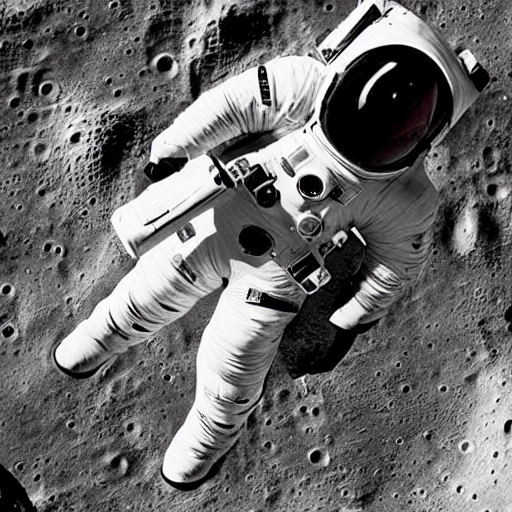

In [15]:
generate_with_embs(modified_output_embeddings,20)

In [16]:
def generate_with_prompt_style(prompt, style, seed):
    embed = torch.load(style)

    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    for t in text_input['input_ids'][0][:20]: # We'll just look at the first 7 to save you from a wall of '<|endoftext|>'
        print(t, tokenizer.decoder.get(int(t)))
    input_ids = text_input.input_ids.to(torch_device)

    token_embeddings = token_emb_layer(input_ids)
    # The new embedding - our special birb word
    replacement_token_embedding = embed[list(embed.keys())[0]].to(torch_device)

    # Insert this into the token embeddings
    token_embeddings[0, torch.where(input_ids[0]==338)] = replacement_token_embedding.to(torch_device)

    # Combine with pos embs
    input_embeddings = token_embeddings + position_embeddings

    #  Feed through to get final output embs
    modified_output_embeddings = get_output_embeds(input_embeddings)

    # And generate an image with this:
    output = generate_with_embs(modified_output_embeddings, seed)
    return output

In [17]:
prompt = 'man sipping wine in spacesuit on moon in style of s'

tensor(49406) <|startoftext|>
tensor(786) man</w>
tensor(28527) sipping</w>
tensor(2604) wine</w>
tensor(530) in</w>
tensor(7857) space
tensor(3940) suit</w>
tensor(525) on</w>
tensor(3293) moon</w>
tensor(530) in</w>
tensor(1844) style</w>
tensor(539) of</w>
tensor(338) s</w>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>


<ipython-input-4-468811b713be>:71: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

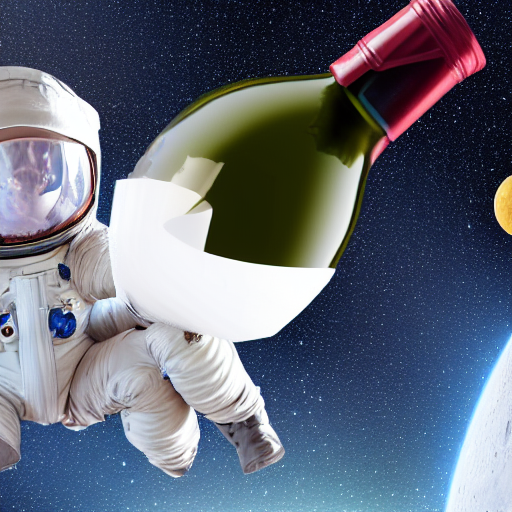

In [18]:
generate_with_prompt_style(prompt,'learned_embeds_bird_style.bin',20)

tensor(49406) <|startoftext|>
tensor(786) man</w>
tensor(28527) sipping</w>
tensor(2604) wine</w>
tensor(530) in</w>
tensor(7857) space
tensor(3940) suit</w>
tensor(525) on</w>
tensor(3293) moon</w>
tensor(530) in</w>
tensor(1844) style</w>
tensor(539) of</w>
tensor(338) s</w>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>


<ipython-input-4-468811b713be>:71: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

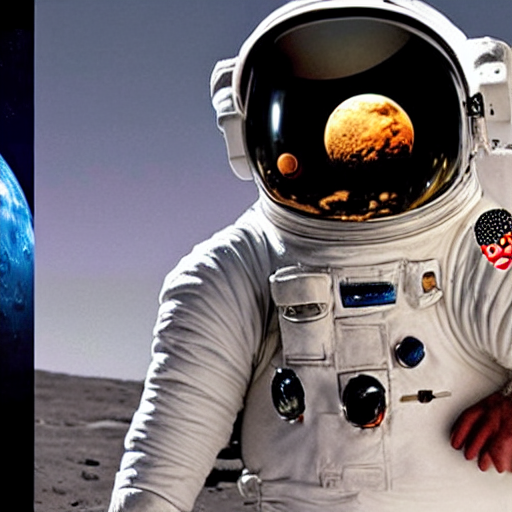

In [19]:
generate_with_prompt_style(prompt,'learned_embeds_captain-haddock.bin',25)

tensor(49406) <|startoftext|>
tensor(786) man</w>
tensor(28527) sipping</w>
tensor(2604) wine</w>
tensor(530) in</w>
tensor(7857) space
tensor(3940) suit</w>
tensor(525) on</w>
tensor(3293) moon</w>
tensor(530) in</w>
tensor(1844) style</w>
tensor(539) of</w>
tensor(338) s</w>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>


<ipython-input-4-468811b713be>:71: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

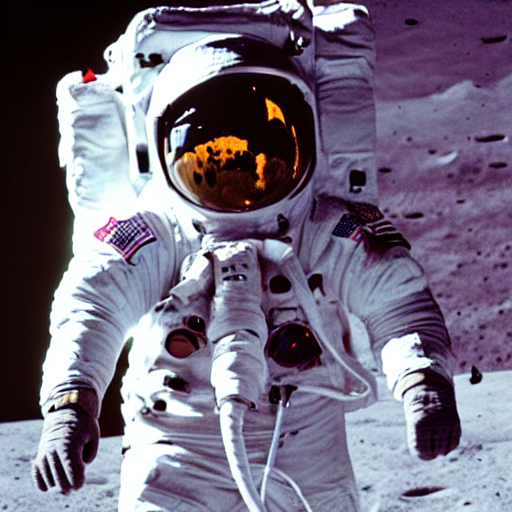

In [20]:
generate_with_prompt_style(prompt,'learned_embeds_doc.bin',30)

tensor(49406) <|startoftext|>
tensor(786) man</w>
tensor(28527) sipping</w>
tensor(2604) wine</w>
tensor(530) in</w>
tensor(7857) space
tensor(3940) suit</w>
tensor(525) on</w>
tensor(3293) moon</w>
tensor(530) in</w>
tensor(1844) style</w>
tensor(539) of</w>
tensor(338) s</w>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>


<ipython-input-4-468811b713be>:71: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

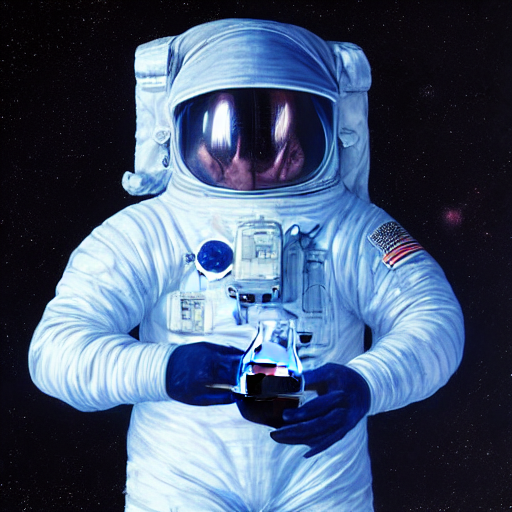

In [21]:
generate_with_prompt_style(prompt,'learned_embeds_blue-haired-boy.bin',35)

tensor(49406) <|startoftext|>
tensor(786) man</w>
tensor(28527) sipping</w>
tensor(2604) wine</w>
tensor(530) in</w>
tensor(7857) space
tensor(3940) suit</w>
tensor(525) on</w>
tensor(3293) moon</w>
tensor(530) in</w>
tensor(1844) style</w>
tensor(539) of</w>
tensor(338) s</w>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>


<ipython-input-4-468811b713be>:71: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

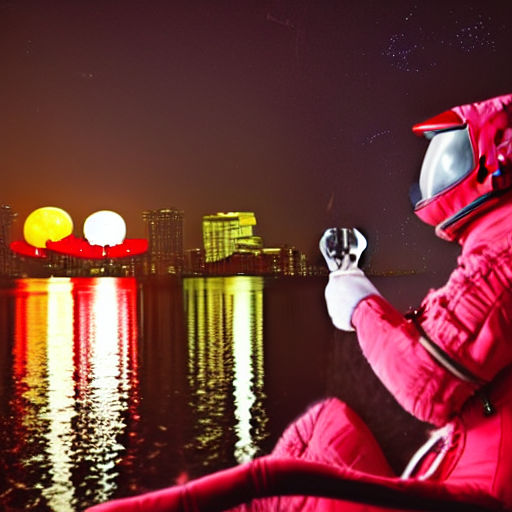

In [22]:
generate_with_prompt_style(prompt,'learned_embeds_fireworks-over-water.bin',40)

In [23]:
import torch

def blue_loss(images):
    variance = torch.var(images)
    return -variance

In [24]:
def generate_with_prompt_style_guidance(prompt, style, seed):

    height = 512                        # default height of Stable Diffusion
    width = 512                         # default width of Stable Diffusion
    num_inference_steps = 50  #           # Number of denoising steps
    guidance_scale = 8 #               # Scale for classifier-free guidance
    generator = torch.manual_seed(seed)   # Seed generator to create the inital latent noise
    batch_size = 1
    blue_loss_scale = 200

    embed = torch.load(style)

    # Prep text
    text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

    input_ids = text_input.input_ids.to(torch_device)

    # Get token embeddings
    token_embeddings = token_emb_layer(input_ids)

    # The new embedding - our special birb word
    replacement_token_embedding = embed[list(embed.keys())[0]].to(torch_device)

    # Insert this into the token embeddings
    token_embeddings[0, torch.where(input_ids[0]==338)] = replacement_token_embedding.to(torch_device)

    # Combine with pos embs
    input_embeddings = token_embeddings + position_embeddings

    #  Feed through to get final output embs
    modified_output_embeddings = get_output_embeds(input_embeddings)

    # And the uncond. input as before:
    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
        [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    set_timesteps(scheduler, num_inference_steps)

    # Prep latents
    latents = torch.randn(
      (batch_size, unet.in_channels, height // 8, width // 8),
      generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform CFG
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        #### ADDITIONAL GUIDANCE ###
        if i%5 == 0:
            # Requires grad on the latents
            latents = latents.detach().requires_grad_()

            # Get the predicted x0:
            latents_x0 = latents - sigma * noise_pred
            # latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

            # Decode to image space
            denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)

            # Calculate loss
            loss = blue_loss(denoised_images) * blue_loss_scale

            # Occasionally print it out
            if i%10==0:
                print(i, 'loss:', loss.item())

            # Get gradient
            cond_grad = torch.autograd.grad(loss, latents)[0]

            # Modify the latents based on this gradient
            latents = latents.detach() - cond_grad * sigma**2

        # Now step with scheduler
        latents = scheduler.step(noise_pred, t, latents).prev_sample


    output = latents_to_pil(latents)[0]
    return output

In [25]:
prompt = 'man sipping wine in spacesuit on moon in style of s'

<ipython-input-24-36c8ad66a914>:49: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss: -12.149703979492188
10 loss: -20.125282287597656
20 loss: -29.17211151123047
30 loss: -33.36368942260742
40 loss: -35.6920166015625


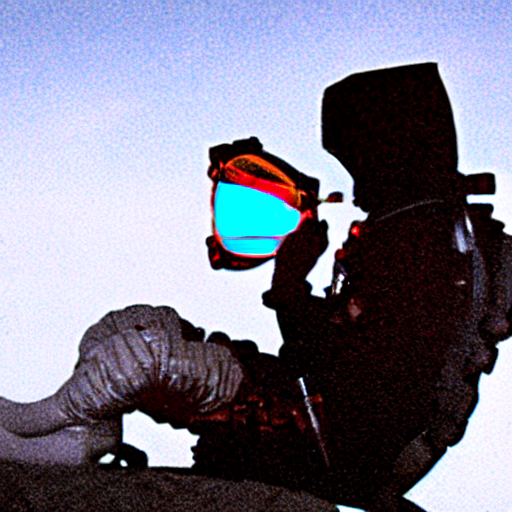

In [26]:
generate_with_prompt_style_guidance(prompt,"learned_embeds_bird_style.bin",20)

<ipython-input-24-36c8ad66a914>:49: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss: -5.622547626495361
10 loss: -16.819652557373047
20 loss: -18.14044952392578
30 loss: -20.464454650878906
40 loss: -21.651172637939453


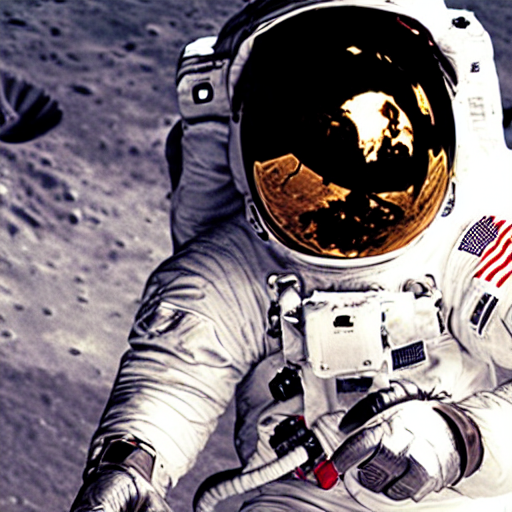

In [27]:
generate_with_prompt_style_guidance(prompt,"learned_embeds_captain-haddock.bin",25)

<ipython-input-24-36c8ad66a914>:49: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss: -9.0057954788208
10 loss: -24.775806427001953
20 loss: -28.42203712463379
30 loss: -30.45769691467285
40 loss: -32.39792251586914


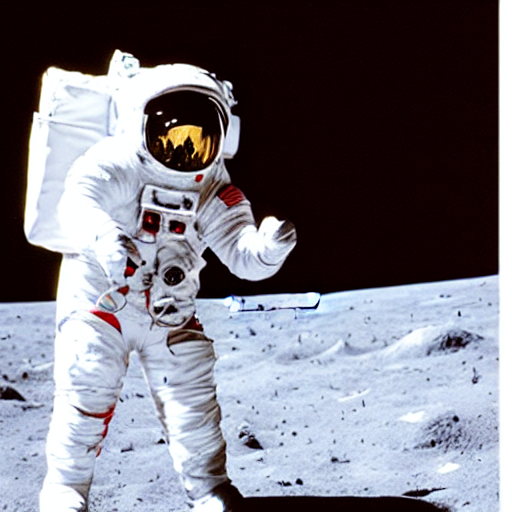

In [28]:
generate_with_prompt_style_guidance(prompt,"learned_embeds_doc.bin",30)

<ipython-input-24-36c8ad66a914>:49: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss: -17.058073043823242
10 loss: -27.324575424194336
20 loss: -33.425567626953125
30 loss: -37.84746170043945
40 loss: -39.20146560668945


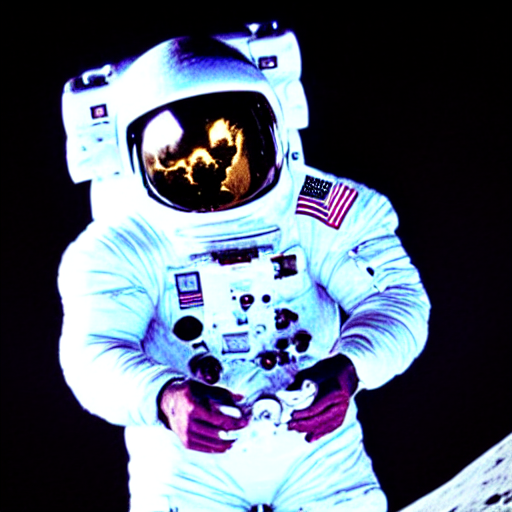

In [29]:
generate_with_prompt_style_guidance(prompt,"learned_embeds_blue-haired-boy.bin",35)

<ipython-input-24-36c8ad66a914>:49: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss: -8.196603775024414
10 loss: -23.239971160888672
20 loss: -31.03240966796875
30 loss: -33.285640716552734
40 loss: -34.263648986816406


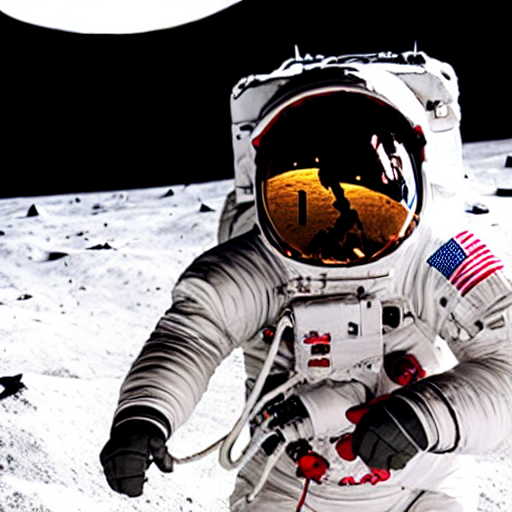

In [30]:
generate_with_prompt_style_guidance(prompt,"learned_embeds_fireworks-over-water.bin",40)